In [1]:
import os
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy

In [2]:
print("Torch Version",torch.__version__)

Torch Version 0.4.1


In [13]:
main_dir = "data/augmented"
data_dir = os.path.join(main_dir, "Wheat")
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [14]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(valid_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/augmented\Wheat\train 0
data/augmented\Wheat\train\loged 3360
data/augmented\Wheat\train\Nonloged 6240
******************************
data/augmented\Wheat\valid 0
data/augmented\Wheat\valid\loged 848
data/augmented\Wheat\valid\Nonloged 1552
******************************
data/augmented\Wheat\test 0
data/augmented\Wheat\test\loged 64
data/augmented\Wheat\test\Nonloged 122


In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [16]:
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomRotation(10, expand=True),
#                                       transforms.CenterCrop(224),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

train_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

valid_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

test_dataset =  torchvision.datasets.ImageFolder(test_dir,
                                                transform=test_transform)

batch_size = 32
dataloaders = {}

dataloaders["train"] = torch.utils.data.DataLoader(train_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["valid"] = torch.utils.data.DataLoader(valid_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["test"] = torch.utils.data.DataLoader(test_dataset,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  num_workers=1)

dataset_sizes = {"train": len(train_dataset), 
                 "valid":len(valid_dataset),
                 "test":len(test_dataset)}

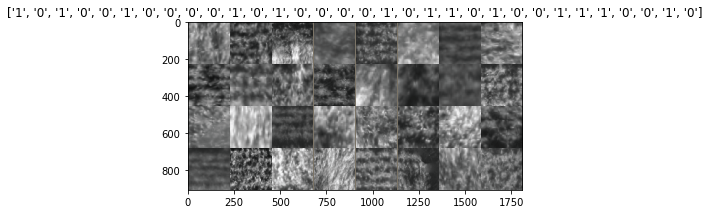

In [17]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[str(x.item()) for x in classes])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
print(dataset_sizes)
print(device)

{'valid': 600, 'train': 600, 'test': 186}
cuda:0


In [21]:
# Building the network
model_ft = torchvision.models.resnet34(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False
fc = torch.nn.Sequential(nn.Linear(512, 512),
                         nn.Dropout(0.2),
                         nn.ReLU(),
                         nn.Linear(512, 2))
model_ft.fc = fc
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(fc.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft,
#                                              step_size=10,
#                                              gamma=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Reza-Lab/.torch\models\resnet34-333f7ec4.pth
100%|████████████████████████████████████████████████████████████████| 87306240/87306240 [00:07<00:00, 11788070.08it/s]


In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
#         print(".", end="", sep="")
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 print(".", end="")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [23]:
if torch.cuda.is_available():
    print("Cuda is available.")
    model_ft = torch.nn.DataParallel(model_ft).cuda();


model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler=None, num_epochs=50)

Cuda is available.
Epoch 0/49
--------------------
train Loss: 0.4349 Acc: 0.8013
valid Loss: 0.3860 Acc: 0.8263

Epoch 1/49
--------------------
train Loss: 0.3911 Acc: 0.8268
valid Loss: 0.3544 Acc: 0.8459

Epoch 2/49
--------------------
train Loss: 0.3837 Acc: 0.8288
valid Loss: 0.3516 Acc: 0.8449

Epoch 3/49
--------------------
train Loss: 0.3838 Acc: 0.8289
valid Loss: 0.3740 Acc: 0.8355

Epoch 4/49
--------------------
train Loss: 0.3756 Acc: 0.8333
valid Loss: 0.3520 Acc: 0.8474

Epoch 5/49
--------------------
train Loss: 0.3670 Acc: 0.8377
valid Loss: 0.3395 Acc: 0.8545

Epoch 6/49
--------------------
train Loss: 0.3625 Acc: 0.8401
valid Loss: 0.3435 Acc: 0.8523

Epoch 7/49
--------------------
train Loss: 0.3751 Acc: 0.8313
valid Loss: 0.3449 Acc: 0.8484

Epoch 8/49
--------------------
train Loss: 0.3637 Acc: 0.8379
valid Loss: 0.3675 Acc: 0.8269

Epoch 9/49
--------------------
train Loss: 0.3661 Acc: 0.8357
valid Loss: 0.3360 Acc: 0.8515

Epoch 10/49
-------------------

In [37]:
torch.save(model_ft.state_dict(), "models/02.wheat_resnet34_augmented.pth")

In [38]:
correct = 0
total = 0
loss = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels)
        
        y_pred += predicted.to("cpu").detach().numpy().tolist()
        y_true += labels.to("cpu").detach().numpy().tolist()
        
print('Test accuracy: {:.4f}' .format( 100 * correct / total))
print('Test Loss: %.4f'%(test_loss))

Test accuracy: 86.5591
Test Loss: 0.2289


In [56]:
# plt.rcParams["axes.grid"] = False
# plt.rcParams.update({'font.size': 20})



# import itertools
# from sklearn.metrics import confusion_matrix

# def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
#     print(cm)
    
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
    
#     fmt = 'd'
#     thresh = cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                 horizontalalignment="center",
#                 color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
    
# def plot_conf_matrix(y_test, y_pred, class_names):
#     cnf_matrix = confusion_matrix(y_test, y_pred)
#     np.set_printoptions(precision=2)
#     print('CCR = {}'.format(np.trace(cnf_matrix) / len(y_test)))
#     plt.figure()
#     plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
#     plt.show()
    
# class_names = ['0', '1']
# plot_conf_matrix(y_true, y_pred, class_names)

Confusion Matrix
[[113   9]
 [ 16  48]]


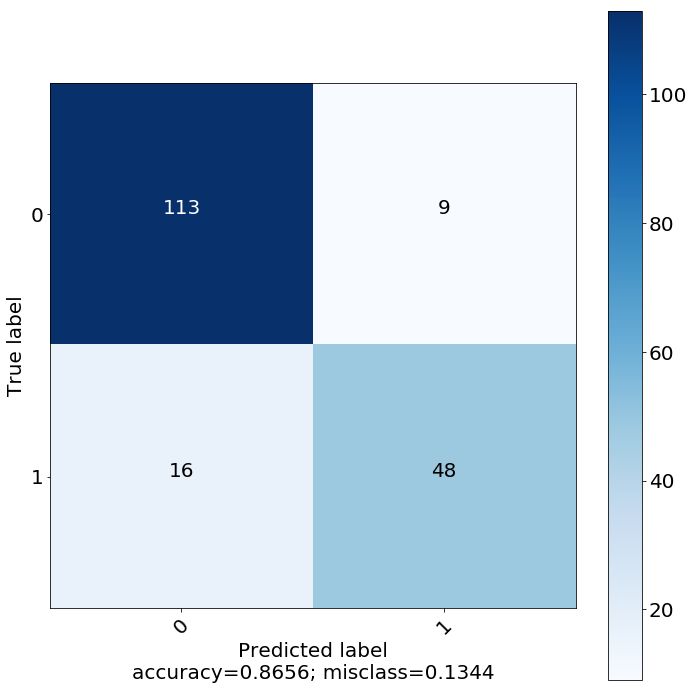

In [55]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

   
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))

labels = ['0', '1']

plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
classnames=[]
for classname in dataloaders["test"]:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_true, y_pred) 
print(confusion_mtx)
target_names = classnames
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred))

[[113   9]
 [ 16  48]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       122
           1       0.84      0.75      0.79        64

   micro avg       0.87      0.87      0.87       186
   macro avg       0.86      0.84      0.85       186
weighted avg       0.86      0.87      0.86       186



In [47]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[113   9]
 [ 16  48]]


In [44]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  86.55913978494624
Sensitivity :  87.59689922480621
Specificity :  84.21052631578947


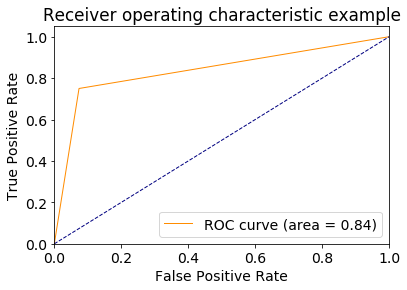

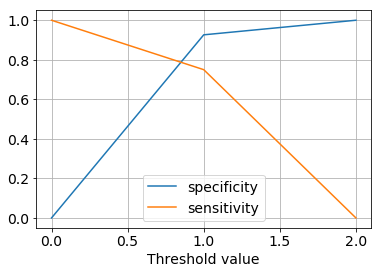

In [45]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [36]:
# To view which layers are freeze and which layers are not freezed:
for name, child in model_ft.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer2.2.conv1.weight False
layer2.2.bn1.weight False
layer2.2.bn1